### Descrição do projeto

Este projeto tem como objetivo analisar a evolução das exportações e importações brasileiras, entre 1997 e 2020, com base em dados públicos disponibilizados pela **Secretaria de comércio Exterior - SECEX **. A análise foi conduzida no ambiente Databricks, abrangendo ingestão de dados bem como modelagem, transformação e análise de dados através de SQL e Python, seguindo as boas práticas do DAMA/DMBOK para governança e documentação.

Os dados (csv) encontram-se no Kaggle: https://www.kaggle.com/datasets/marcelopesse/brazil-exportimport-information?resource=download&select=IMP_COMPLETA.csv


### Objetivo
Investigar padrões históricos de comércio exterior brasileiro e identiricar oportunidades estratégicas para aumentar as exportações brasileiras nos próximos 5 anos.



[📄 Clique aqui para acessar a documentação completa (PDF)](files/tables/documentacao/Documentacao_MVP_ENGENHARIA_DE_DADOS_WALLACE_CONCEICAO.pdf)


### Problema Central
Apesar do grande volume em sua atividade comercial internacional no Brasil, ainda existem lacunas quanto à identificação de setores e países com maior potencial de expansão das operações.
O desafio é: **Entender quais produtos, parceiros comerciais e canais logísticos oferecem as melhores oportunidades de crescimento das exportações**


### 5 Perguntas para o Problema:
1. Quais foram os principais produtos exportados e importados pelo Brasil entre 1997 e 2020, em termos de volume e valor?
2. Quais países tiveram maior relevância nas relações comerciais com o Brasil e como isto evoluiu ao longo dos anos?
3. Quais estados e municípios brasileiros mais contribuíram para a balança comercial nacional?
4. Como as vias de transporte e unidades de despacho (URFs) influenciaram o desempenho logístico das operações de comércio exterior?
5. Com base no histório, quais setores apresentam maior potencial de crescimento nas exportações nos próximos 5 anos?

### Documentação dos dados
Nessa parte é trazido o Catálogo dos dados (Seguindo DAMA/DMBOK), Dicionário de dados e Metadados:

Iremos abordar sobre qualidade dos dados e linhagem de dados durante a análise e ao final do projeto, respectivamente.


### Ingestão dos dados

Os dados foram salvos no Google Drive devido a limitação de tamanho em 2GB na ingestão direta no DBFS no Databricks e termos uma planilha que ultrapassa esse tamanho.


In [0]:
# 1 - Criando Banco de dados COMEXBR no Databricks e pasta no DBFS
spark.sql("CREATE DATABASE IF NOT EXISTS COMEXBR")
import os
os.makedirs("/dbfs/FileStore/COMEXBR/raw", exist_ok=True)
dbutils.fs.mkdirs("dbfs:/FileStore/COMEXBR/raw/")


# 1.1 - Verificando e recriando tabelas Delta caso não estejam registradas no catálogo
tabelas_delta = ["fato_exportacao", "fato_importacao"]

for tabela in tabelas_delta:
    path = f"/user/hive/warehouse/comexbr.db/{tabela}"
    if not spark._jsparkSession.catalog().tableExists("COMEXBR", tabela):
        spark.sql(f"""
            CREATE TABLE COMEXBR.{tabela}
            USING DELTA
            LOCATION 'dbfs:{path}'
        """)
        print(f"Tabela {tabela} recriada com sucesso.")
    else:
        print(f"Tabela {tabela} já está registrada.")


# 2 - Criando dicionário com os nomes das tabelas e seus respectivos IDs do Google Drive para facilitar o acesso aos arquivos.

google_drive_files = {
    "NCM":         "1N4kCCe6JgopmG6RYrPxL-pz0zg6OutKj",
    "PAIS":        "1E_u93AY79JRK8Wi-yRNx0Zx0LhPwsSM1",
    "PAIS_BLOCO":  "1yqe9sFA5ZPN1Nq4cVFYk63Wj-0oMzO9N",
    "UF":          "1OnmFWbsH3ueOCoGLz5xli1MfAqj8HrLE",
    "UF_MUN":      "1zNCH_9lN1-lxcP3JEvnbrrqzQm4cPxZq",
    "URF":         "1J6bItA41yxJhQAaVXJAttAq_LGMq25m9",
    "VIA":         "1mm86mXFpEHHKKTq9B_U69pAg-Qyf28IW",
    "EXP_COMPLETA": "1hEEmaWOXgXM-DcqKQxi7EXxZTnKnl8ih",
    "IMP_COMPLETA": "1YV9RjGfmIOKYfSe6x3Z2AAZyQqR8HBe1"
}


Tabela fato_exportacao recriada com sucesso.
Tabela fato_importacao recriada com sucesso.


In [0]:
# 3 - Download via gdown e não via requests devido ao tamanho grande de alguns arquivos. Criada função em Python para obter as bases da lista:
%pip install gdown
import gdown

def download_csv(arquivo_nome, file_id):
    import gdown
    import os

    local_tmp = f"/tmp/{arquivo_nome}.csv"
    final_dbfs = f"dbfs:/FileStore/COMEXBR/raw/{arquivo_nome}.csv"

    print(f"Baixando {arquivo_nome}")
    gdown.download(f"https://drive.google.com/uc?id={file_id}", local_tmp, quiet=False)

    if not os.path.exists(local_tmp):
        raise FileNotFoundError(f"Arquivo {arquivo_nome} não foi salvo em {local_tmp}")

    # Copiar do /tmp/ local para o DBFS
    dbutils.fs.cp(f"file://{local_tmp}", final_dbfs)
    print(f"Salvo em: {final_dbfs}")
    return final_dbfs


# 4 - Baixando todos os arquivos do dicionário criado
arquivos_dbfs = {}

for nome, file_id in google_drive_files.items():
    caminho = download_csv(nome, file_id)
    arquivos_dbfs[nome] = caminho

  Obtaining dependency information for gdown from https://files.pythonhosted.org/packages/54/70/e07c381e6488a77094f04c85c9caf1c8008cdc30778f7019bc52e5285ef0/gdown-5.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for beautifulsoup4 from https://files.pythonhosted.org/packages/f9/49/6abb616eb3cbab6a7cca303dc02fdf3836de2e0b834bf966a7f5271a34d8/beautifulsoup4-4.13.3-py3-none-any.whl.metadata
  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/d0/30/dc54f88dd4a2b5dc8a0279bdd7270e735851848b762aeb1c1184ed1f6b14/tqdm-4.67.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/57.7 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.6 MB/s eta 0:00:00
  Obtaining dependency information for soupsieve>1.2 from https://files.pythonhosted.org/packages/d1/c2/fe97d779f3ef3b15f05c94a2f1e3d21732574ed441687474db9d342a7315/soupsieve-2.6-py3-none-any.whl.metadata
  Obtaining dependency information for P

Downloading...
From: https://drive.google.com/uc?id=1N4kCCe6JgopmG6RYrPxL-pz0zg6OutKj
To: /tmp/NCM.csv
100%|██████████| 3.13M/3.13M [00:00<00:00, 27.5MB/s]


Salvo em: dbfs:/FileStore/COMEXBR/raw/NCM.csv
Baixando PAIS


Downloading...
From: https://drive.google.com/uc?id=1E_u93AY79JRK8Wi-yRNx0Zx0LhPwsSM1
To: /tmp/PAIS.csv
100%|██████████| 17.4k/17.4k [00:00<00:00, 7.03MB/s]


Salvo em: dbfs:/FileStore/COMEXBR/raw/PAIS.csv
Baixando PAIS_BLOCO


Downloading...
From: https://drive.google.com/uc?id=1yqe9sFA5ZPN1Nq4cVFYk63Wj-0oMzO9N
To: /tmp/PAIS_BLOCO.csv
100%|██████████| 23.9k/23.9k [00:00<00:00, 5.12MB/s]


Salvo em: dbfs:/FileStore/COMEXBR/raw/PAIS_BLOCO.csv
Baixando UF


Downloading...
From: https://drive.google.com/uc?id=1OnmFWbsH3ueOCoGLz5xli1MfAqj8HrLE
To: /tmp/UF.csv
100%|██████████| 1.50k/1.50k [00:00<00:00, 1.10MB/s]


Salvo em: dbfs:/FileStore/COMEXBR/raw/UF.csv
Baixando UF_MUN


Downloading...
From: https://drive.google.com/uc?id=1zNCH_9lN1-lxcP3JEvnbrrqzQm4cPxZq
To: /tmp/UF_MUN.csv
100%|██████████| 252k/252k [00:00<00:00, 8.53MB/s]


Salvo em: dbfs:/FileStore/COMEXBR/raw/UF_MUN.csv
Baixando URF


Downloading...
From: https://drive.google.com/uc?id=1J6bItA41yxJhQAaVXJAttAq_LGMq25m9
To: /tmp/URF.csv
100%|██████████| 10.5k/10.5k [00:00<00:00, 37.1MB/s]


Salvo em: dbfs:/FileStore/COMEXBR/raw/URF.csv
Baixando VIA


Downloading...
From: https://drive.google.com/uc?id=1mm86mXFpEHHKKTq9B_U69pAg-Qyf28IW
To: /tmp/VIA.csv
100%|██████████| 369/369 [00:00<00:00, 2.44MB/s]


Salvo em: dbfs:/FileStore/COMEXBR/raw/VIA.csv
Baixando EXP_COMPLETA


Downloading...
From (original): https://drive.google.com/uc?id=1hEEmaWOXgXM-DcqKQxi7EXxZTnKnl8ih
From (redirected): https://drive.google.com/uc?id=1hEEmaWOXgXM-DcqKQxi7EXxZTnKnl8ih&confirm=t&uuid=80862d33-3703-4c99-beed-55bd38cda3d2
To: /tmp/EXP_COMPLETA.csv
100%|██████████| 1.50G/1.50G [00:13<00:00, 113MB/s] 


Salvo em: dbfs:/FileStore/COMEXBR/raw/EXP_COMPLETA.csv
Baixando IMP_COMPLETA


Downloading...
From (original): https://drive.google.com/uc?id=1YV9RjGfmIOKYfSe6x3Z2AAZyQqR8HBe1
From (redirected): https://drive.google.com/uc?id=1YV9RjGfmIOKYfSe6x3Z2AAZyQqR8HBe1&confirm=t&uuid=d5955c23-3bc9-49b3-86fa-b204caf96013
To: /tmp/IMP_COMPLETA.csv
100%|██████████| 2.26G/2.26G [00:26<00:00, 85.0MB/s]


Salvo em: dbfs:/FileStore/COMEXBR/raw/IMP_COMPLETA.csv


In [0]:

# 5 - Definição de Schemas das tabelas baixadas para tratamento no sql

from pyspark.sql.types import *

schemas = {
    "NCM": StructType([
        StructField("CO_NCM", StringType(), True),
        StructField("CO_UNID", StringType(), True),
        StructField("CO_SH6", StringType(), True),
        StructField("CO_PPE", StringType(), True),
        StructField("CO_PPI", StringType(), True),
        StructField("CO_FAT_AGREG", StringType(), True),
        StructField("CO_CUCI_ITEM", StringType(), True),
        StructField("CO_CGCE_N3", StringType(), True),
        StructField("CO_SIIT", StringType(), True),
        StructField("CO_ISIC_CLASSE", StringType(), True),
        StructField("CO_EXP_SUBSET", StringType(), True),
        StructField("NO_NCM_POR", StringType(), True),
        StructField("NO_NCM_ESP", StringType(), True),
        StructField("NO_NCM_ING", StringType(), True),
    ]),

    "PAIS": StructType([
        StructField("CO_PAIS", StringType(), True),
        StructField("CO_PAIS_ISON3", StringType(), True),
        StructField("CO_PAIS_ISOA3", StringType(), True),
        StructField("NO_PAIS", StringType(), True),
        StructField("NO_PAIS_ING", StringType(), True),
        StructField("NO_PAIS_ESP", StringType(), True),
    ]),

    "PAIS_BLOCO": StructType([
        StructField("CO_PAIS", StringType(), True),
        StructField("CO_BLOCO", StringType(), True),
        StructField("NO_BLOCO", StringType(), True),
        StructField("NO_BLOCO_ING", StringType(), True),
        StructField("NO_BLOCO_ESP", StringType(), True),
    ]),

    "UF": StructType([
        StructField("CO_UF", StringType(), True),
        StructField("SG_UF", StringType(), True),
        StructField("NO_UF", StringType(), True),
        StructField("NO_REGIAO", StringType(), True),
    ]),

    "UF_MUN": StructType([
        StructField("CO_MUN_GEO", StringType(), True),
        StructField("NO_MUN", StringType(), True),
        StructField("NO_MUN_MIN", StringType(), True),
        StructField("SG_UF", StringType(), True),
    ]),

    "URF": StructType([
        StructField("CO_URF", StringType(), True),
        StructField("NO_URF", StringType(), True),
    ]),

    "VIA": StructType([
        StructField("CO_VIA", StringType(), True),
        StructField("NO_VIA", StringType(), True),
    ]),

    "EXP_COMPLETA": StructType([
        StructField("CO_ANO", IntegerType(), True),
        StructField("CO_MES", IntegerType(), True),
        StructField("CO_NCM", StringType(), True),
        StructField("CO_UNID", StringType(), True),
        StructField("CO_PAIS", StringType(), True),
        StructField("SG_UF_NCM", StringType(), True),
        StructField("CO_VIA", StringType(), True),
        StructField("CO_URF", StringType(), True),
        StructField("QT_ESTAT", IntegerType(), True),
        StructField("KG_LIQUIDO", FloatType(), True),
        StructField("VL_FOB", FloatType(), True),
    ]),

    "IMP_COMPLETA": StructType([
        StructField("CO_ANO", IntegerType(), True),
        StructField("CO_MES", IntegerType(), True),
        StructField("CO_NCM", StringType(), True),
        StructField("CO_UNID", StringType(), True),
        StructField("CO_PAIS", StringType(), True),
        StructField("SG_UF_NCM", StringType(), True),
        StructField("CO_VIA", StringType(), True),
        StructField("CO_URF", StringType(), True),
        StructField("QT_ESTAT", IntegerType(), True),
        StructField("KG_LIQUIDO", FloatType(), True),
        StructField("VL_FOB", FloatType(), True),
    ]),
}


In [0]:

# 6 - Lendo com Pyspark e verificando registros nas tabelas para verificar se deu certo

dataframes = {}

for nome, path in arquivos_dbfs.items():
    print(f"\nLendo {nome} de {path}")
    df = (
        spark.read
        .option("header", True)
        .option("sep", ";")
        .option("encoding", "latin1")
        .csv(path)
    )
    dataframes[nome] = df
    
    print(f"{nome} carregado com {df.count()} registros")




Lendo NCM de dbfs:/FileStore/COMEXBR/raw/NCM.csv
NCM carregado com 13118 registros

Lendo PAIS de dbfs:/FileStore/COMEXBR/raw/PAIS.csv
PAIS carregado com 282 registros

Lendo PAIS_BLOCO de dbfs:/FileStore/COMEXBR/raw/PAIS_BLOCO.csv
PAIS_BLOCO carregado com 323 registros

Lendo UF de dbfs:/FileStore/COMEXBR/raw/UF.csv
UF carregado com 34 registros

Lendo UF_MUN de dbfs:/FileStore/COMEXBR/raw/UF_MUN.csv
UF_MUN carregado com 5570 registros

Lendo URF de dbfs:/FileStore/COMEXBR/raw/URF.csv
URF carregado com 275 registros

Lendo VIA de dbfs:/FileStore/COMEXBR/raw/VIA.csv
VIA carregado com 17 registros

Lendo EXP_COMPLETA de dbfs:/FileStore/COMEXBR/raw/EXP_COMPLETA.csv
EXP_COMPLETA carregado com 22398370 registros

Lendo IMP_COMPLETA de dbfs:/FileStore/COMEXBR/raw/IMP_COMPLETA.csv
IMP_COMPLETA carregado com 33491095 registros


### Ingestão de Dados - Persistência das tabelas no Delta Lake

Os DataFrames que você carregados com .csv(...) vivem apenas durante a execução da sessão. Quando o cluster reinicia, tudo pode (e provavelmente será) perdido. 

Nesse caso, gravar como tabela Delta garante que:

Os dados ficam armazenados fisicamente no DBFS

Podem ser acessados via SQL ou Spark a qualquer momento

In [0]:
# 7 - Persistência das tabelas de dimensão no banco COMEXBR

dimensoes = {
    "NCM": "dim_ncm",
    "PAIS": "dim_pais",
    "PAIS_BLOCO": "dim_pais_bloco",
    "UF": "dim_uf",
    "UF_MUN": "dim_uf_mun",
    "URF": "dim_urf",
    "VIA": "dim_via"
}


for nome_df, nome_sql in dimensoes.items():
    df = dataframes[nome_df]
    print(f"Gravando {nome_sql} como tabela Delta...")
    
    df.write.format("delta") \
        .mode("overwrite") \
        .saveAsTable(f"COMEXBR.{nome_sql}")
    
    print(f"Tabela COMEXBR.{nome_sql} gravada com sucesso.")


    # ao final, listando tabelas gravadas como verificação

spark.sql("SHOW TABLES IN COMEXBR").show(truncate=False)



Gravando dim_ncm como tabela Delta...
Tabela COMEXBR.dim_ncm gravada com sucesso.
Gravando dim_pais como tabela Delta...
Tabela COMEXBR.dim_pais gravada com sucesso.
Gravando dim_pais_bloco como tabela Delta...
Tabela COMEXBR.dim_pais_bloco gravada com sucesso.
Gravando dim_uf como tabela Delta...
Tabela COMEXBR.dim_uf gravada com sucesso.
Gravando dim_uf_mun como tabela Delta...
Tabela COMEXBR.dim_uf_mun gravada com sucesso.
Gravando dim_urf como tabela Delta...
Tabela COMEXBR.dim_urf gravada com sucesso.
Gravando dim_via como tabela Delta...
Tabela COMEXBR.dim_via gravada com sucesso.
+--------+---------------+-----------+
|database|tableName      |isTemporary|
+--------+---------------+-----------+
|comexbr |dim_ncm        |false      |
|comexbr |dim_pais       |false      |
|comexbr |dim_pais_bloco |false      |
|comexbr |dim_uf         |false      |
|comexbr |dim_uf_mun     |false      |
|comexbr |dim_urf        |false      |
|comexbr |dim_via        |false      |
|comexbr |fato_e

### Etapa adicional
 Ponto relevante: Durante a criação das views SQL, foi possível identificar que o schema definido com tipos float não foi efetivamente aplicado pelo PySpark. Isso ocorreu, possivelmente, devido a inconsistências na formatação dos valores numéricos nos arquivos CSV — em especial, o uso de pontos como separadores de milhar e vírgulas como separadores decimais, conforme o padrão brasileiro.

Essa constatação reforça a importância da análise crítica dos dados durante o processo de ingestão e transformação. Mais do que garantir a execução técnica do pipeline, é fundamental assegurar que os dados produzidos façam sentido e estejam coerentes com o domínio da informação. Esse tipo de verificação não apenas contribui para a qualidade da solução final, como representa um aspecto essencial no desenvolvimento de habilidades profissionais em projetos de dados.

In [0]:
# 8 - Sanitização garantindo que os valores numéricos sejam realmente float, convertendo do formato brasileiro (com ponto e vírgula) para o padrão americano

# Criando uma função para transformação de colunas numéricas
from pyspark.sql.functions import regexp_replace, col

def limpar_coluna_valor(df, nome_coluna):
    return (
        df.withColumn(f"{nome_coluna}_tmp", regexp_replace(col(nome_coluna), "\\.", ""))  # remove pontos de milhar
          .withColumn(f"{nome_coluna}_tmp", regexp_replace(col(f"{nome_coluna}_tmp"), ",", "."))  # troca vírgula decimal
          .withColumn(f"{nome_coluna}_tmp", col(f"{nome_coluna}_tmp").cast("float"))  # converte para float
          .drop(nome_coluna)
          .withColumnRenamed(f"{nome_coluna}_tmp", nome_coluna)
    )


# Leitura e limpeza da tabela fato_exportacao (sem schema fixo para preservar os valores originais)
df_exp = (
    spark.read
    .option("header", True)
    .option("sep", ";")
    .option("encoding", "latin1")
    .csv(arquivos_dbfs["EXP_COMPLETA"])
)

# Sanitização de colunas numéricas
df_exp = limpar_coluna_valor(df_exp, "VL_FOB")
df_exp = limpar_coluna_valor(df_exp, "KG_LIQUIDO")
df_exp = limpar_coluna_valor(df_exp, "QT_ESTAT")

# Persistência no formato Delta
spark.sql("DROP TABLE IF EXISTS COMEXBR.fato_exportacao")

df_exp.write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("COMEXBR.fato_exportacao")

print("Tabela fato_exportacao gravada com sucesso.")


# Leitura e limpeza da tabela fato_importacao (sem schema fixo para preservar os valores originais)
df_imp = (
    spark.read
    .option("header", True)
    .option("sep", ";")
    .option("encoding", "latin1")
    .csv(arquivos_dbfs["IMP_COMPLETA"])
)

# Sanitização de colunas numéricas
df_imp = limpar_coluna_valor(df_imp, "VL_FOB")
df_imp = limpar_coluna_valor(df_imp, "KG_LIQUIDO")
df_imp = limpar_coluna_valor(df_imp, "QT_ESTAT")

# Persistência no formato Delta
spark.sql("DROP TABLE IF EXISTS COMEXBR.fato_importacao")

df_imp.write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("COMEXBR.fato_importacao")

print("Tabela fato_importacao gravada com sucesso.")



Tabela fato_exportacao gravada com sucesso.
Tabela fato_importacao gravada com sucesso.


In [0]:
# 9 - Verificando as tabelas e registros para garantir o processo

dataframes = {}

for nome, path in arquivos_dbfs.items():
    if path is None:
        print(f"Erro: caminho de {nome} está vazio ou inválido. Verifique o download.")
        continue

    print(f"\nLendo {nome} de {path}")
    df = (
        spark.read
        .option("header", True)
        .option("sep", ";")
        .option("encoding", "latin1")
        .csv(path)
    )
    dataframes[nome] = df

    print(f"{nome} carregado com {df.count()} registros")



Lendo NCM de dbfs:/FileStore/COMEXBR/raw/NCM.csv
NCM carregado com 13118 registros

Lendo PAIS de dbfs:/FileStore/COMEXBR/raw/PAIS.csv
PAIS carregado com 282 registros

Lendo PAIS_BLOCO de dbfs:/FileStore/COMEXBR/raw/PAIS_BLOCO.csv
PAIS_BLOCO carregado com 323 registros

Lendo UF de dbfs:/FileStore/COMEXBR/raw/UF.csv
UF carregado com 34 registros

Lendo UF_MUN de dbfs:/FileStore/COMEXBR/raw/UF_MUN.csv
UF_MUN carregado com 5570 registros

Lendo URF de dbfs:/FileStore/COMEXBR/raw/URF.csv
URF carregado com 275 registros

Lendo VIA de dbfs:/FileStore/COMEXBR/raw/VIA.csv
VIA carregado com 17 registros

Lendo EXP_COMPLETA de dbfs:/FileStore/COMEXBR/raw/EXP_COMPLETA.csv
EXP_COMPLETA carregado com 22398370 registros

Lendo IMP_COMPLETA de dbfs:/FileStore/COMEXBR/raw/IMP_COMPLETA.csv
IMP_COMPLETA carregado com 33491095 registros


In [0]:
%sql
-- Confirmando se as tabelas foram persistidas
SHOW TABLES IN COMEXBR;



 

database,tableName,isTemporary
comexbr,dim_ncm,false
comexbr,dim_pais,false
comexbr,dim_pais_bloco,false
comexbr,dim_uf,false
comexbr,dim_uf_mun,false
comexbr,dim_urf,false
comexbr,dim_via,false
comexbr,fato_exportacao,false
comexbr,fato_importacao,false


## Enriquecimento de tabelas, informação e transformação de dados - Esquema Estrela Materializado

In [0]:
%sql
-- 10 - Criando uma view para cada tabela de COMEX - Enriquecidas com informações de tabelas dimensão.

-- Exportação:
CREATE OR REPLACE TABLE COMEXBR.vw_exportacao AS
SELECT 
    f.CO_ANO            AS ANO_EXPORTACAO,
    f.CO_MES            AS MES_EXPORTACAO,
    f.CO_NCM            AS CODIGO_MERCADORIA,
    f.CO_PAIS           AS CODIGO_PAIS,
    f.SG_UF_NCM         AS UF_ORIGEM,
    f.CO_VIA            AS CODIGO_MODAL,
    f.CO_URF            AS CODIGO_UNIDADE_DESPACHO,
    f.QT_ESTAT,
    f.KG_LIQUIDO        AS PESO_EXPORTADO_KG,
    f.VL_FOB            AS VALOR_MERCADORIA_DOLARES,
    n.NO_NCM_POR        AS NCM_DESCRICAO,
    p.NO_PAIS           AS PAIS_DESTINO,
    v.NO_VIA            AS MODAL_TRANSPORTE,
    r.NO_URF            AS UNIDADE_DESPACHO,
    u.NO_UF             AS UF_ORIGEM_NOME,
    u.NO_REGIAO         AS REGIAO_ORIGEM,
    CONCAT(f.CO_ANO, '-', LPAD(f.CO_MES,2,'0')) AS ANO_MES,
    CASE
        WHEN f.CO_MES BETWEEN 1 AND 3 THEN 'T1'
        WHEN f.CO_MES BETWEEN 4 AND 6 THEN 'T2'
        WHEN f.CO_MES BETWEEN 7 AND 9 THEN 'T3'
        WHEN f.CO_MES BETWEEN 10 AND 12 THEN 'T4'
        ELSE 'Desconhecido'
    END AS TRIMESTRE,
    CONCAT(LPAD(f.CO_MES, 2,'0'),'/',f.CO_ANO) AS ANO_MES_LABEL


FROM COMEXBR.fato_exportacao AS f
LEFT JOIN COMEXBR.dim_ncm AS n ON TRIM(f.CO_NCM) = TRIM(n.CO_NCM)
LEFT JOIN COMEXBR.dim_pais AS p ON TRIM(f.CO_PAIS) = TRIM(p.CO_PAIS)
LEFT JOIN COMEXBR.dim_uf AS u ON TRIM(f.SG_UF_NCM) = TRIM(u.SG_UF)
LEFT JOIN COMEXBR.dim_via AS v ON TRIM(f.CO_VIA) = TRIM(v.CO_VIA)
LEFT JOIN COMEXBR.dim_urf AS r ON TRIM(f.CO_URF) = TRIM(r.CO_URF);


num_affected_rows,num_inserted_rows


In [0]:
%sql
-- Importação:
CREATE OR REPLACE TABLE COMEXBR.vw_importacao AS
SELECT 
    f.CO_ANO            AS ANO_IMPORTACAO,
    f.CO_MES            AS MES_IMPORTACAO,
    CONCAT(f.CO_ANO, '-', LPAD(f.CO_MES, 2, '0')) AS ANO_MES,
    CASE 
        WHEN f.CO_MES BETWEEN 1 AND 3  THEN 'T1'
        WHEN f.CO_MES BETWEEN 4 AND 6  THEN 'T2'
        WHEN f.CO_MES BETWEEN 7 AND 9  THEN 'T3'
        WHEN f.CO_MES BETWEEN 10 AND 12 THEN 'T4'
        ELSE 'Desconhecido'
    END AS TRIMESTRE,
    CONCAT(LPAD(f.CO_MES, 2, '0'), '/', f.CO_ANO) AS ANO_MES_LABEL,

    f.CO_NCM            AS CODIGO_MERCADORIA,
    f.CO_PAIS           AS CODIGO_PAIS,
    f.SG_UF_NCM         AS UF_DESTINO,
    f.CO_VIA            AS CODIGO_MODAL,
    f.CO_URF            AS CODIGO_UNIDADE_DESPACHO,
    f.QT_ESTAT,
    f.KG_LIQUIDO        AS PESO_IMPORTADO_KG,
    f.VL_FOB            AS VALOR_MERCADORIA_DOLARES,

    n.NO_NCM_POR        AS NCM_DESCRICAO,
    p.NO_PAIS           AS PAIS_ORIGEM,
    v.NO_VIA            AS MODAL_TRANSPORTE,
    r.NO_URF            AS UNIDADE_DESPACHO,
    u.NO_UF             AS UF_DESTINO_NOME,
    u.NO_REGIAO         AS REGIAO_DESTINO

FROM COMEXBR.fato_importacao AS f
LEFT JOIN COMEXBR.dim_ncm  AS n ON TRIM(f.CO_NCM)    = TRIM(n.CO_NCM)
LEFT JOIN COMEXBR.dim_pais AS p ON TRIM(f.CO_PAIS)   = TRIM(p.CO_PAIS)
LEFT JOIN COMEXBR.dim_uf   AS u ON TRIM(f.SG_UF_NCM) = TRIM(u.SG_UF)
LEFT JOIN COMEXBR.dim_via  AS v ON TRIM(f.CO_VIA)    = TRIM(v.CO_VIA)
LEFT JOIN COMEXBR.dim_urf  AS r ON TRIM(f.CO_URF)    = TRIM(r.CO_URF);


num_affected_rows,num_inserted_rows


In [0]:
%sql
-- Verificação das Views criadas
SELECT * FROM COMEXBR.vw_importacao LIMIT 5;


ANO_IMPORTACAO,MES_IMPORTACAO,ANO_MES,TRIMESTRE,ANO_MES_LABEL,CODIGO_MERCADORIA,CODIGO_PAIS,UF_DESTINO,CODIGO_MODAL,CODIGO_UNIDADE_DESPACHO,QT_ESTAT,PESO_IMPORTADO_KG,VALOR_MERCADORIA_DOLARES,NCM_DESCRICAO,PAIS_ORIGEM,MODAL_TRANSPORTE,UNIDADE_DESPACHO,UF_DESTINO_NOME,REGIAO_DESTINO
1997,12,1997-12,T4,12/1997,02012090,845,RS,07,1011000,416342.0,416342.0,606408.0,"Outras peças não desossadas de bovino, frescas ou refrigeradas",Uruguai,RODOVIARIA,1011000 - SANTANA DO LIVRAMENTO,Rio Grande do Sul,REGIAO SUL
1997,12,1997-12,T4,12/1997,85366990,386,SP,04,0817600,66673.0,448.0,20528.0,"Outras tomadas de corrente, para uma tensão não superior a 1.000 V",Itália,AEREA,0817600 - AEROPORTO INTERNACIONAL DE SAO PAULO/GUARULHOS,São Paulo,REGIAO SUDESTE
1997,12,1997-12,T4,12/1997,74191000,190,SP,04,0817600,2131.0,2131.0,12212.0,"Correntes, cadeias, e suas partes, de cobre",Coreia do Sul,AEREA,0817600 - AEROPORTO INTERNACIONAL DE SAO PAULO/GUARULHOS,São Paulo,REGIAO SUDESTE
1997,12,1997-12,T4,12/1997,45049000,244,CE,04,0717700,26.0,26.0,28.0,Outras obras de cortiça aglomerada,Emirados Árabes Unidos,AEREA,0717700 - AEROPORTO INTERNACIONAL DO RIO DE JANEIRO,Ceará,REGIAO NORDESTE
1997,12,1997-12,T4,12/1997,25070090,245,SC,01,0925100,10000.0,10000.0,2016.0,"Outras argilas caulínicas, mesmo calcinadas",Espanha,MARITIMA,0925100 - ITAJAI,Santa Catarina,REGIAO SUL


In [0]:
%sql

-- Verificação das Views criadas
SELECT * FROM COMEXBR.vw_exportacao LIMIT 5;

ANO_EXPORTACAO,MES_EXPORTACAO,CODIGO_MERCADORIA,CODIGO_PAIS,UF_ORIGEM,CODIGO_MODAL,CODIGO_UNIDADE_DESPACHO,QT_ESTAT,PESO_EXPORTADO_KG,VALOR_MERCADORIA_DOLARES,NCM_DESCRICAO,PAIS_DESTINO,MODAL_TRANSPORTE,UNIDADE_DESPACHO,UF_ORIGEM_NOME,REGIAO_ORIGEM,ANO_MES,TRIMESTRE,ANO_MES_LABEL
1997,03,41043911,149,RS,01,1010500,3987.0,4150.0,16725.0,"Outros couros/peles, de bovino, preparado após curtimento, sem acabamento",Canadá,MARITIMA,1010500 - RIO GRANDE,Rio Grande do Sul,REGIAO SUL,1997-03,T1,03/1997
1997,05,63019000,097,MG,07,0145200,0.0,1002.0,8420.0,Outros cobertores e mantas,Bolívia,RODOVIARIA,0145200 - CORUMBA,Minas Gerais,REGIAO SUDESTE,1997-05,T2,05/1997
1997,06,87168000,586,RS,07,0145300,48.0,153.0,915.0,Outros veículos não autopropulsores,Paraguai,RODOVIARIA,0145300 - PONTA PORA,Rio Grande do Sul,REGIAO SUL,1997-06,T2,06/1997
1997,08,39162000,249,SP,01,0817800,0.0,138.0,586.0,"Monofilamentos (monofios), etc, de polímeros de cloreto de vinila",Estados Unidos,MARITIMA,0817800 - PORTO DE SANTOS,São Paulo,REGIAO SUDESTE,1997-08,T3,08/1997
1997,02,73130000,063,SP,07,1010900,0.0,2714.0,1972.0,"Arame farpado, de ferro ou aço; arames ou tiras, retorcidos, mesmo farpados, de ferro ou aço, dos tipos utilizados em cercas",Argentina,RODOVIARIA,1010900 - URUGUAIANA,São Paulo,REGIAO SUDESTE,1997-02,T1,02/1997


## Análise Exploratória dos dados.
Após ingestão, tratamentos dos dados e criação das views iremos para a etapa de análise exploratória dos dados, respondendo às perguntas propostas.


##### Pergunta 1 - "Quais os principais países de destino das exportações brasileiras e origem das importações no período analisado"

TOP **10**

In [0]:
## Top 10 países 

# Coletando os dados das views para o Python
df_top_export = spark.sql("""
    SELECT PAIS_DESTINO, SUM(VALOR_MERCADORIA_DOLARES) AS TOTAL_EXPORTADO
    FROM COMEXBR.vw_exportacao
    GROUP BY PAIS_DESTINO
    ORDER BY TOTAL_EXPORTADO DESC
    LIMIT 10
""").toPandas()

df_top_import = spark.sql("""
    SELECT PAIS_ORIGEM, SUM(VALOR_MERCADORIA_DOLARES) AS TOTAL_IMPORTADO
    FROM COMEXBR.vw_importacao
    GROUP BY PAIS_ORIGEM
    ORDER BY TOTAL_IMPORTADO DESC
    LIMIT 10
""").toPandas()



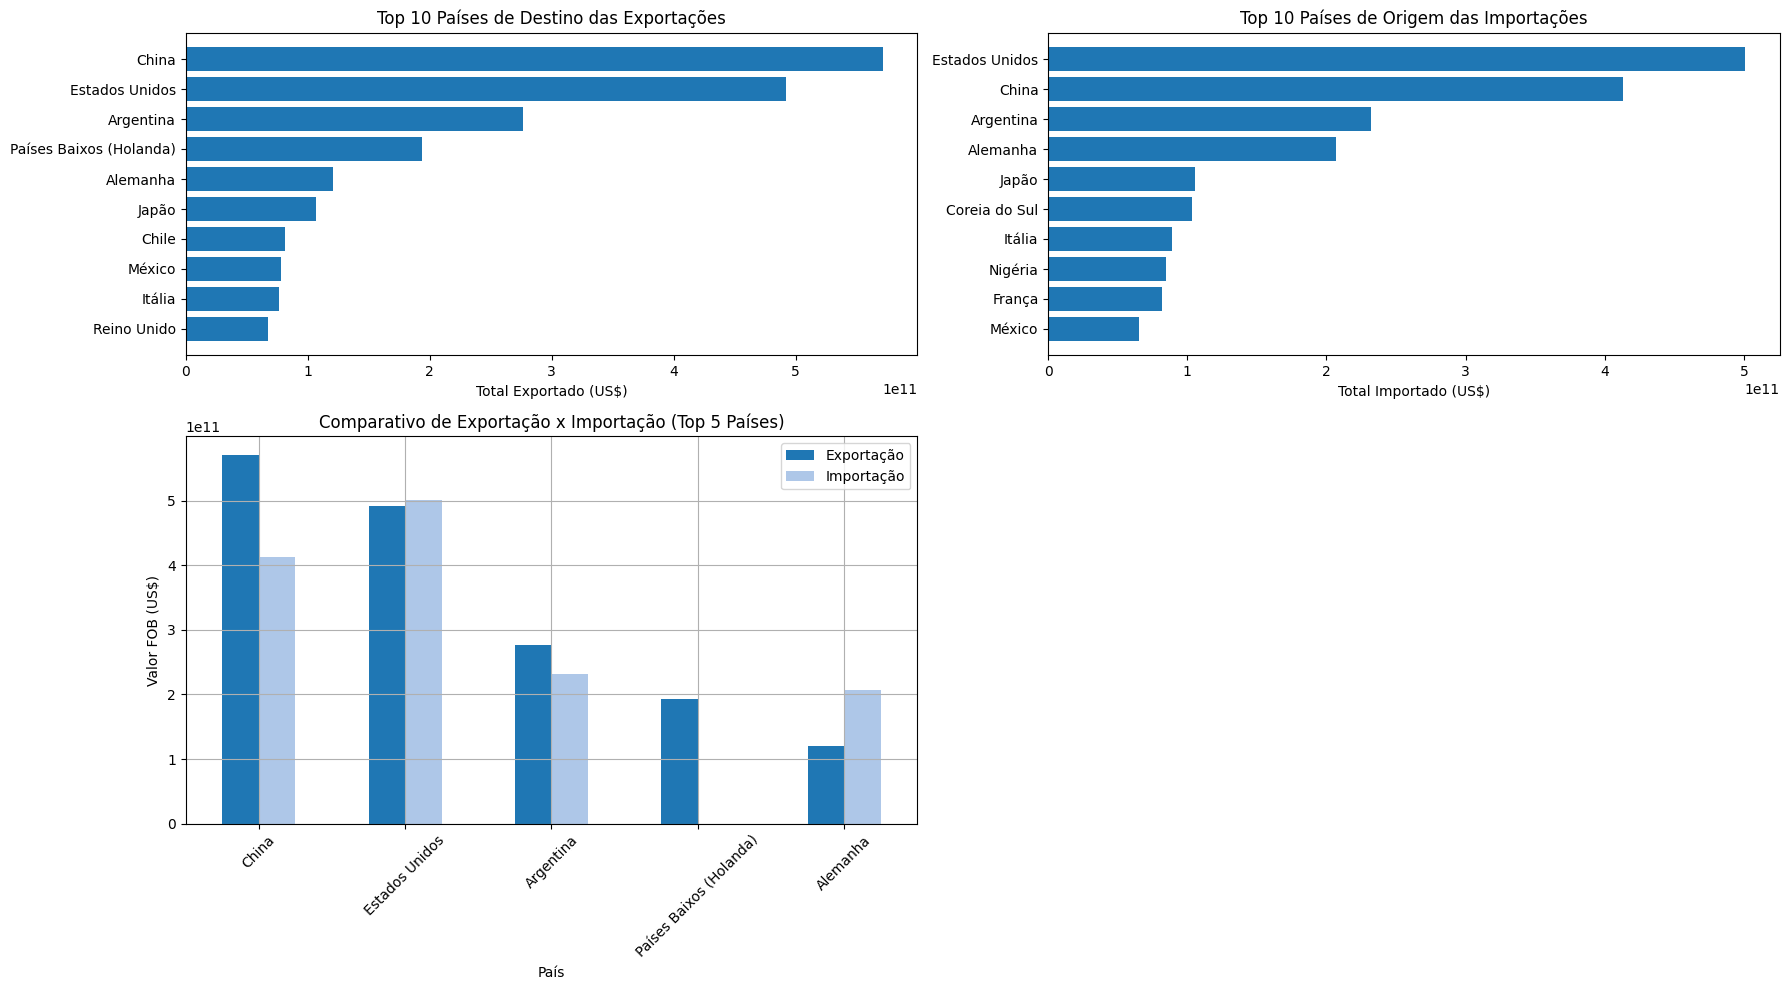

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
# Define a paleta de cores
azul_escuro = "#1f77b4"
azul_claro = "#aec7e8"

# Criando o layout com 2 linhas: 1ª linha com 2 gráficos lado a lado, 2ª linha com 1 gráfico maior
fig, axs = plt.subplots(2, 2, figsize=(18, 10), gridspec_kw={'height_ratios': [1, 1.2]})

# Gráfico 1: Exportações
axs[0, 0].barh(df_top_export["PAIS_DESTINO"], df_top_export["TOTAL_EXPORTADO"], color=azul_escuro)
axs[0, 0].set_title("Top 10 Países de Destino das Exportações")
axs[0, 0].set_xlabel("Total Exportado (US$)")
axs[0, 0].invert_yaxis()

# Gráfico 2: Importações
axs[0, 1].barh(df_top_import["PAIS_ORIGEM"], df_top_import["TOTAL_IMPORTADO"], color=azul_escuro)
axs[0, 1].set_title("Top 10 Países de Origem das Importações")
axs[0, 1].set_xlabel("Total Importado (US$)")
axs[0, 1].invert_yaxis()


# Unificando os dados por país para comparação entre exportação e importação
df_merge = pd.merge(
    df_top_export.rename(columns={"PAIS_DESTINO": "PAIS"}),
    df_top_import.rename(columns={"PAIS_ORIGEM": "PAIS"}),
    on="PAIS",
    how="outer"
).fillna(0)

# Top 5 países com maiores valores (exportação ou importação)
df_top5 = df_merge.sort_values(
    by=["TOTAL_EXPORTADO", "TOTAL_IMPORTADO"], ascending=False
).head(5)

# Gráfico 3: Comparativo (exportação vs importação) — Top 5
df_top5.set_index("PAIS").plot(kind="bar", color=[azul_escuro, azul_claro], ax=axs[1, 0])

axs[1, 0].set_title("Comparativo de Exportação x Importação (Top 5 Países)")
axs[1, 0].set_ylabel("Valor FOB (US$)")
axs[1, 0].set_xlabel("País")
axs[1, 0].legend(["Exportação", "Importação"])
axs[1, 0].grid(True)
axs[1, 0].tick_params(axis='x', rotation=45)

# Remove o 4º espaço (vazio) e ajusta layout
fig.delaxes(axs[1, 1])
plt.tight_layout()
plt.show()


##### Pergunta 2 - "Quais os principais produtos exportados e importados pelo BRasil em termos de valor FOB?"

TOP 10

In [0]:
## Top 10 países 

# Coletando os dados das views para o Python

df_top_prod_export = spark.sql("""
    SELECT NCM_DESCRICAO, SUM(VALOR_MERCADORIA_DOLARES) AS TOTAL_EXPORTADO
    FROM COMEXBR.vw_exportacao
    GROUP BY NCM_DESCRICAO
    ORDER BY TOTAL_EXPORTADO DESC
    LIMIT 10
""").toPandas()

df_top_prod_import = spark.sql("""
    SELECT NCM_DESCRICAO, SUM(VALOR_MERCADORIA_DOLARES) AS TOTAL_IMPORTADO
    FROM COMEXBR.vw_importacao
    GROUP BY NCM_DESCRICAO
    ORDER BY TOTAL_IMPORTADO DESC
    LIMIT 10
""").toPandas()


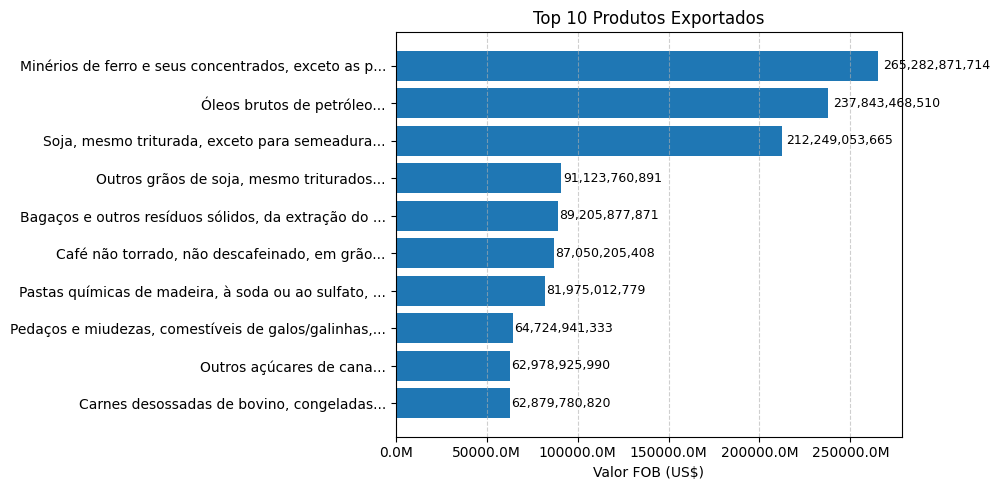

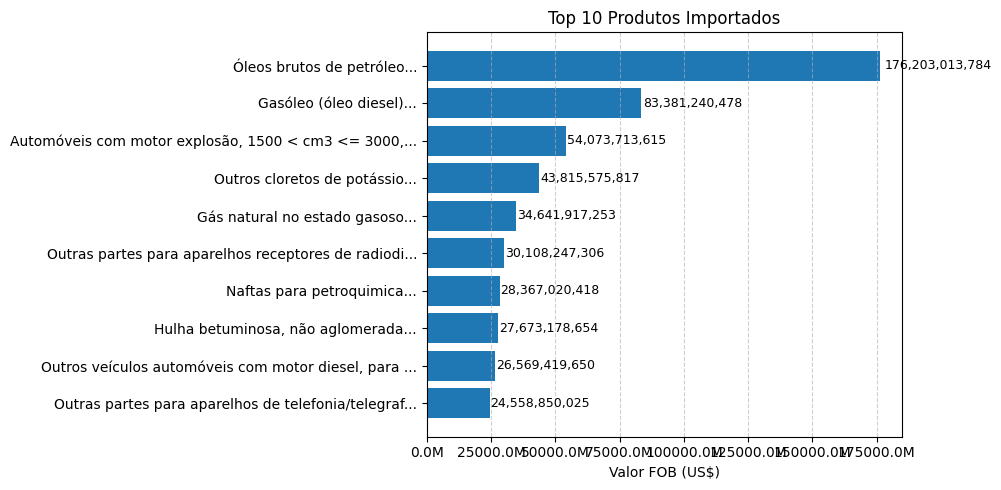

In [0]:
# Truncando nomes longos
df_top_prod_export["NCM_LABEL"] = df_top_prod_export["NCM_DESCRICAO"].str.slice(0, 50) + "..."
df_top_prod_import["NCM_LABEL"] = df_top_prod_import["NCM_DESCRICAO"].str.slice(0, 50) + "..."


def plot_horizontal_bar(df, valor_col, label_col, titulo):
    plt.figure(figsize=(10, 5))
    bars = plt.barh(df[label_col], df[valor_col], color=azul_escuro)
    
    
    for bar in bars:
        width = bar.get_width()
        plt.text(width + width*0.01, bar.get_y() + bar.get_height()/2, f"{width:,.0f}", va='center', fontsize=9)

    plt.xlabel("Valor FOB (US$)")
    plt.title(titulo)
    plt.gca().invert_yaxis()
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    
    
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

    plt.tight_layout()
    plt.show()


plot_horizontal_bar(df_top_prod_export, "TOTAL_EXPORTADO", "NCM_LABEL", "Top 10 Produtos Exportados")
plot_horizontal_bar(df_top_prod_import, "TOTAL_IMPORTADO", "NCM_LABEL", "Top 10 Produtos Importados")




##### Pergunta 3 - "Quais são as Unidades da Federação (UFs) com maiores volumes de exportação e importação?"

TOP **10**

In [0]:
# Top 10 UFs por exportação
df_top_uf_export = spark.sql("""
    SELECT UF_ORIGEM_NOME AS UF, SUM(VALOR_MERCADORIA_DOLARES) AS TOTAL_EXPORTADO
    FROM COMEXBR.vw_exportacao
    GROUP BY UF_ORIGEM_NOME
    ORDER BY TOTAL_EXPORTADO DESC
    LIMIT 10
""").toPandas()

# Top 10 UFs por importação (ajuste no nome da coluna)
df_top_uf_import = spark.sql("""
    SELECT UF_DESTINO_NOME AS UF, SUM(VALOR_MERCADORIA_DOLARES) AS TOTAL_IMPORTADO
    FROM COMEXBR.vw_importacao
    GROUP BY UF_DESTINO_NOME
    ORDER BY TOTAL_IMPORTADO DESC
    LIMIT 10
""").toPandas()




In [0]:
!pip install plotly geopandas > /dev/null 2>&1
subunitcolor = "white"

import pandas as pd
import plotly.express as px

# Consulta no Spark
df_exp_uf = spark.sql("""
    SELECT UF_ORIGEM_NOME AS UF, SUM(VALOR_MERCADORIA_DOLARES) AS TOTAL_EXPORTADO
    FROM COMEXBR.vw_exportacao
    GROUP BY UF_ORIGEM_NOME
""").toPandas()

# Mapa de exportações
fig_exp = px.choropleth(
    df_exp_uf,
    geojson="https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson",
    featureidkey="properties.name",
    locations="UF",
    color="TOTAL_EXPORTADO",
    color_continuous_scale="Blues",
    scope="south america",
    labels={"TOTAL_EXPORTADO": "Exportado (US$)"},
    title="Exportações por UF (Valor FOB)"
)

fig_exp.update_geos(
    fitbounds="locations",
    visible=False,
    showcountries=True,
    showsubunits=True,
    subunitcolor="black",
    showland=True,
    landcolor="white"
)

fig_exp.update_layout(
    margin={"r":0,"t":50,"l":0,"b":0},
    paper_bgcolor="white"
)

fig_exp.show()




Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import pandas as pd
import plotly.express as px

# Consulta no Spark
df_imp_uf = spark.sql("""
    SELECT UF_DESTINO_NOME AS UF, SUM(VALOR_MERCADORIA_DOLARES) AS TOTAL_IMPORTADO
    FROM COMEXBR.vw_importacao
    GROUP BY UF_DESTINO_NOME
""").toPandas()

# Mapa de importações
fig_imp = px.choropleth(
    df_imp_uf,
    geojson="https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson",
    featureidkey="properties.name",
    locations="UF",
    color="TOTAL_IMPORTADO",
    color_continuous_scale="Blues",
    scope="south america",
    labels={"TOTAL_IMPORTADO": "Importado (US$)"},
    title="Importações por UF (Valor FOB)"
)

fig_imp.update_geos(
    fitbounds="locations",
    visible=False,
    showcountries=True,
    showsubunits=True,
    subunitcolor="black",
    showland=True,
    landcolor="white"
)

fig_imp.update_layout(
    margin={"r":0,"t":50,"l":0,"b":0},
    paper_bgcolor="white"
)

fig_imp.show()


##### Pergunta 4 - "Quais os principais modais logísticos utilizados nas operações de importação e exportação ao longo do tempo?"

TOP **5**


In [0]:
# Exportação
df_modal_export = spark.sql("""
    SELECT MODAL_TRANSPORTE, SUM(VALOR_MERCADORIA_DOLARES) AS TOTAL_EXPORTADO
    FROM COMEXBR.vw_exportacao
    GROUP BY MODAL_TRANSPORTE
    ORDER BY TOTAL_EXPORTADO DESC
    LIMIT 5
""").toPandas()

# Importação
df_modal_import = spark.sql("""
    SELECT MODAL_TRANSPORTE, SUM(VALOR_MERCADORIA_DOLARES) AS TOTAL_IMPORTADO
    FROM COMEXBR.vw_importacao
    GROUP BY MODAL_TRANSPORTE
    ORDER BY TOTAL_IMPORTADO DESC
    LIMIT 5
""").toPandas()


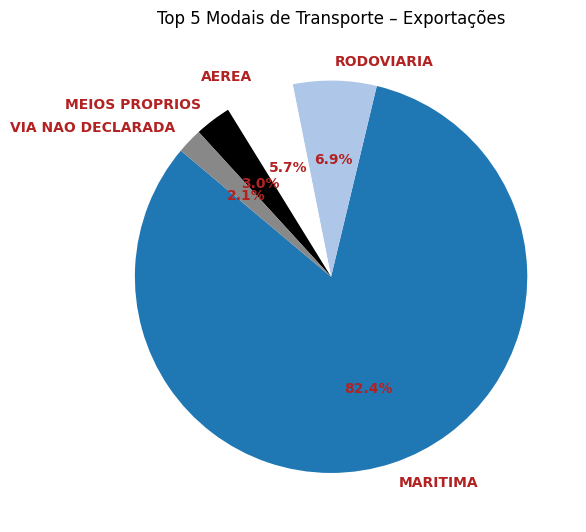

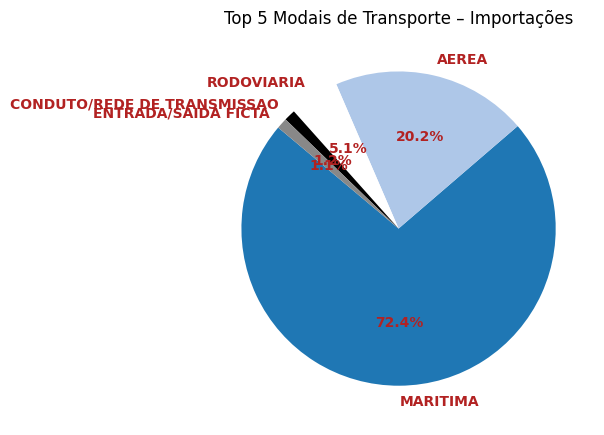

In [0]:
# Paleta personalizada
paleta_cores = ["#1f77b4", "#aec7e8", "#ffffff", "#000000", "#888888"]

# Exportações
plt.figure(figsize=(6, 6))
plt.pie(
    df_modal_export["TOTAL_EXPORTADO"],
    labels=df_modal_export["MODAL_TRANSPORTE"],
    autopct="%1.1f%%",
    startangle=140,
    colors=paleta_cores,
    textprops=dict(color="firebrick",fontweight='bold') 
)
plt.title("Top 5 Modais de Transporte – Exportações")
plt.tight_layout()
plt.show()

# Importações
plt.figure(figsize=(6, 6))
plt.pie(
    df_modal_import["TOTAL_IMPORTADO"],
    labels=df_modal_import["MODAL_TRANSPORTE"],
    autopct="%1.1f%%",
    startangle=140,
    colors=paleta_cores,
    textprops=dict(color="firebrick",fontweight='bold') 
)
plt.title("Top 5 Modais de Transporte – Importações")
plt.tight_layout()
plt.show()


##### Pergunta 5 - "Como as exportações e importações variam ao longo do tempo?"


In [0]:
import plotly.express as px
import plotly.io as pio
pio.templates.default = None  
pio.templates.default = "plotly_white"


df_exp_ano = spark.sql("""
    SELECT ANO_EXPORTACAO AS ANO, SUM(VALOR_MERCADORIA_DOLARES) AS TOTAL_EXPORTADO
    FROM COMEXBR.vw_exportacao
    GROUP BY ANO_EXPORTACAO
""").toPandas()

df_imp_ano = spark.sql("""
    SELECT ANO_IMPORTACAO AS ANO, SUM(VALOR_MERCADORIA_DOLARES) AS TOTAL_IMPORTADO
    FROM COMEXBR.vw_importacao
    GROUP BY ANO_IMPORTACAO
""").toPandas()


In [0]:

# Merge para gráfico combinado
df_ano = pd.merge(df_exp_ano, df_imp_ano, on="ANO", how="outer").sort_values(by="ANO")

# Gráfico de linhas
fig = px.line(
    df_ano,
    x="ANO",
    y=["TOTAL_EXPORTADO", "TOTAL_IMPORTADO"],
    labels={
        "value": "Valor FOB (US$)",
        "variable": "Tipo",
        "ANO": "Ano"
    },
    color_discrete_map={
        "TOTAL_EXPORTADO": "#1f77b4",
        "TOTAL_IMPORTADO": "#aec7e8"   
    },
    title="Exportações e Importações por Ano (FOB US$)"
)

fig.update_layout(
    template="plotly_white",
    title_font=dict(size=18),
    legend_title_text="",
    margin=dict(l=20, r=20, t=60, b=40)
)

fig.show()

### Conclusões Finais

1.	Resumo do aprendizado e reflexões:
O projeto me permitiu esse primeiro contato com a área de Engenharia de dados. Não atuo na área de engenharia de dados, na verdade, estou buscando aprimorar a análise de dados e construir conhecimentos em ciência de dados, portanto, essa visão de construção de pipeline foi sensacional. A plataforma Databricks em sua versão gratuita tem suas limitações como efemeridade dos dados, limitações de tamanho de fonte de dados para ingestão de dados a serem salvos no DBFS (o que me levou a criar um diretório no Google Drive) questões de inatividade de recursos após 60 minutos, tempo mais extenso de processamento, entre outros.
Embora isto esteja atrelado a versão gratuita, mostra, em certa medida, os desafios que o engenheiro de dados enfrente no dia a dia. A aplicação de ferramentas e linguagens como Pyspark, SQl, Pandas, Matplotlib e Plotly também enriqueceram o aprendizado. 
“Codei” utilizando conhecimentos próprios, pesquisando muito, vendo vídeos e também obtendo auxílio para retirada de dúvidas com a Inteligência Artificial que de fato acelera muito a aprendizagem. 
Passeio por etapas de ingestão de dados, sanitização de dados, modelagem dimensiona em estrela, construção de views e visualizações (ETL)
A manipulação de dados em grande escala utilizando Spark, bem como a efemeridade dos dados, como dito acima (e a necessidade de sua persistência) foram prontos críticos e fontes de aprendizagem.

2.	 Insights Principais sobre a análise
Estados como SP, MG e RJ concentram a maior parte das exportações e importações do país demonstrando com dados que a região Sudeste ainda é determinante para a balança comercial brasileira.
Produtos como minérios e combustíveis lideram o volume de exportação.
A China e os Estados Unidos surgem como os principais parceiros comerciais em ambas as direções, seguidos pela Argentina em menor nível.
Há uma forte consistência nas rotas logísticas, com modais marítimos dominando a exportação. Porém isso demonstra uma deficiência clara em modais férreos, reconhecidamente mais baratos e rápidos.
Exportações e importações apresentam crescimento sólido até 2019, com oscilações em 2020 (provavelmente devido à pandemia).

3.	Limitações
A granularidade dos dados está em nível mensal, mas algumas análises foram feitas apenas de forma agregada (anual ou total devido a facilitação na análise e plotagem gráfica)
Algumas colunas importantes exigiram sanitização complexa por conta de diferenças regionais de formatação (ex: separador decimal). – Mas isso foi um ponto estranho, vendo até no próprio site, valores que deveria ser FLOAT são, em CSV, já vindos com formato INTEGER. 
Os dados não incluem informações sobre câmbio, fretes, ou outros custos associados que poderiam enriquecer a análise financeira.
Como o Databricks Community tem limitações de cluster, algumas operações mais pesadas foram otimizadas, adaptadas ou reduzidas.


## Autoavaliação

Apesar de ter compreendido bem o fluxo completo de um pipeline de dados — desde a ingestão, modelagem e transformação até a análise e visualização — reconheço que ainda há pontos importantes a desenvolver, especialmente no que se refere à lógica de programação e à criação de funções em Python.

Tenho facilidade em interpretar etapas do processo e identificar as ferramentas mais adequadas para cada contexto. No entanto, percebo certa dificuldade em estruturar rotinas mais complexas com fluidez, como funções generalizadas (def) e estruturas de repetição (loops).

Vejo esse desafio como parte natural da curva de aprendizado e estou comprometido em aprimorar essas habilidades. Acredito que, com estudo contínuo e prática regular, principalmente voltada à lógica de programação aplicada, conseguirei evoluir para um nível mais autônomo e fluente no desenvolvimento de soluções em ciência de dados com Python.

Além disso, sinto que é fundamental estar inserido em um ambiente profissional que estimule desafios reais na área de dados, ciência de dados e tecnologias em nuvem. Isso será essencial para meu crescimento técnico e para solidificar o conhecimento adquirido neste projeto.